# Milestone Project - SkimLit
This is a project for the SkimLit application, which is designed to help users quickly skim through articles and extract key information. This will make reading medical abstracts easier.

Now, we start by classifying the articles into different categories based on their content. The project uses TensorFlow for building and training the model. 

For example, we're going to classify articles into categories such as "Background", "Methods", "Results", and "Conclusion", etc. The model will be trained on a dataset of articles, and it will learn to predict the category of a new article based on its content.

## Import libraries and modules


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import os # For checking filenames

2025-09-13 20:49:13.324905: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-13 20:49:13.339944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757771353.359408   21403 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757771353.365769   21403 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757771353.380581   21403 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Download dataset and load it into tensors
In this model, we will use PubMed articles dataset, which contains a collection of biomedical literature.
Then we will find the most wrong prediction.

### Input - output:
**Input**: a paragraph relate on a topic or a subtitle that encoded into numerical tensor (tokenization and embedding)

**Output**: predicted output (a tensor of probabilities of predictions) base on our model working. This answer the question: `"What section should these sentences belong to?"`

In [2]:
#!cd datasets & git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git 
! cd datasets & ls pubmed-rct

In [3]:
! ls datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
! ls datasets/pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [4]:
# Using "20k datasets" with numbers replaced by "@" sign
data_dir = "datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocessing data
It's time to become one with it.
The best way is visualizating them!

In [5]:
# Function for read all content in lines of a document
def get_lines(filename):
    """
    read filename and returns the lines of text as a list.

    Args:
        filename (str): containing the target filepath
    """
    with open(filename, "r") as f:
        return f.readlines()

In [6]:
# Read in training line
train_lines = get_lines(data_dir + "train.txt")
train_lines

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
test_lines = get_lines(data_dir + "test.txt")
test_lines[:10]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

The form of data would be presented on is:
> [{
>    
>    'line_number': 0,
>
>    'target': 'BACKGROUND'
>
>   'text' : 'e.g. \n'
>
>    'total_line': 11
>
> }, ...]

In [8]:
# Fucntion turns each of out datasets into above format
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename) # get all line of filename
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list of abstracts
    
    for line in input_lines:
        if line.startswith("###"): # Check if this is an ID line
            abstract_id = line
            abstract_lines = "" # reset the abstract_lines
        elif line.isspace():
            abstract_lines_split = abstract_lines.splitlines()
    
             # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_lines_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                if len(target_text_split) < 2:
                    continue
                line_data = {
                    "line_number": abstract_line_number,
                    "target": target_text_split[0],
                    "text": target_text_split[1].lower(),
                    "total_lines": len(abstract_lines_split) - 1
                }

                abstract_samples.append(line_data)
        else: # the line contains a labelled sentence
            abstract_lines += line
    
    return abstract_samples

In [9]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name of validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [10]:
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [11]:
len(train_lines)

210040

We need to turn into DataFrame if wanna further visualize them

In [12]:
# Turn into dataframe
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

print(train_df.head(14))
print(train_df.target.value_counts())

    line_number       target  \
0             0    OBJECTIVE   
1             1      METHODS   
2             2      METHODS   
3             3      METHODS   
4             4      METHODS   
5             5      METHODS   
6             6      RESULTS   
7             7      RESULTS   
8             8      RESULTS   
9             9      RESULTS   
10           10      RESULTS   
11           11  CONCLUSIONS   
12            0   BACKGROUND   
13            1   BACKGROUND   

                                                 text  total_lines  
0   to investigate the efficacy of @ weeks of dail...           11  
1   a total of @ patients with primary knee oa wer...           11  
2   outcome measures included pain reduction and i...           11  
3   pain was assessed using the visual analog pain...           11  
4   secondary outcome measures included the wester...           11  
5   serum levels of interleukin @ ( il-@ ) , il-@ ...           11  
6   there was a clinically relevant 

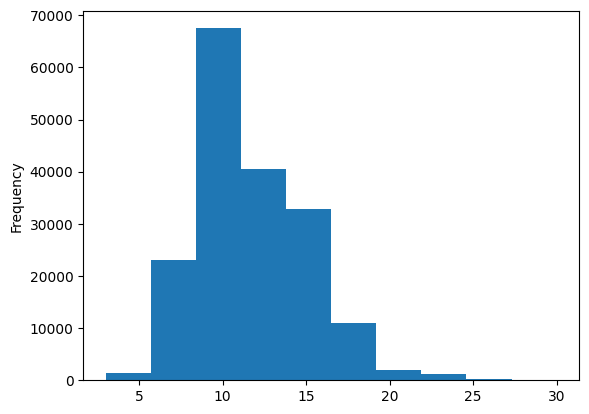

In [13]:
# Check the length of the different lines
train_df.total_lines.plot.hist();

In [14]:
# Get lists of sentences
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

### Turn our labels in to numerical tensor embedded
*Machine Learning requires numerical values as inputs and outputs.*

**One hot encoder**

In [15]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output= False) # we want non_sparse matrix

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

In [16]:
tf.constant(train_labels_one_hot)

2025-09-13 20:49:18.625903: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

**Label encode labels**

In [17]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

## Get class names and numer of classes from LabelEncoder instance

In [18]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [19]:
# Download the helper function
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [20]:
from helper_functions import calculate_results

## Trainning with various types of models

### Model 0: Naive Bayes with TF-IDF

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

Nice! Looks like *72.2%* accuracy will be the number to beat with our deeper models.

Now let's make some predictions with our baseline model to further evaluate it.

In [23]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
baseline_results = calculate_results(y_true=val_labels_encoded, y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

*That is the end of model 0 with Tf Idf, for deeper upgrade, we have to prepare our data further.*

### Preparing data for deep learning model
We can use the `TextVectorization` layer from TensorFlow to turn our text into embedded numerical tensors.

Average length: 26.338269273494777


(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

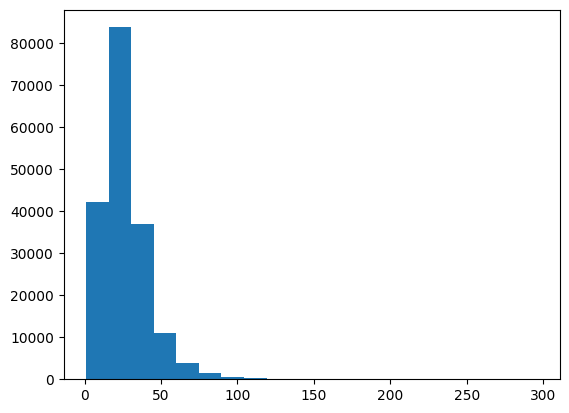

In [25]:
from tensorflow.keras import layers
import numpy as np
# How long is each sentence on average
sentence_len = [len(sentence.split()) for sentence in train_sentences]
sentence_len

print(f"Average length: {np.mean(sentence_len)}")
plt.hist(sentence_len, bins=20)

In [26]:
output_seq_len = int(np.percentile(sentence_len, 95))
print(output_seq_len)
print(np.max(sentence_len))

55
296


Wonderful! It looks like 95% of the sentences in our training set have a length of 55 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).

### Creating a text vectorization layer

In [27]:
# Define max_tokens
max_tokens = 68000

# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=output_seq_len)

Adapt text vectorizer to training sentences

In [28]:
text_vectorizer.adapt(train_sentences)

`TextVectorization` lưu một bảng tra cứu token → index ở bên trong (dùng TensorFlow lookup table).

Nếu bạn chưa gọi `.adapt()` thì bảng đó rỗng, nên khi gọi `.call()` (tức là khi bạn làm text_vectorizer([...])) nó sẽ báo "table not initialized".

👉 Sau khi `.adapt(train_sentences)`, nó mới biết từ nào trong vocabulary để map thành số.

Test our text vectorizer on random training sentences

In [29]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\n Vectorized text: {text_vectorizer([target_sentence])}") 

Text:
the authors , therefore , sought to determine the effect of using a percutaneous superior vena cava catheter on brain near-infrared spectroscopy , blood lactate levels , hemodynamics and surgical parameters .

Length of text: 208

 Vectorized text: [[   2 1473  709 1193    6  228    2   70    4   59    8 1109  496 6994
  7920 1025   18  623 8402 5535  107 2225   93 3750    3  306  315    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [30]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [31]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom-text embedding
*Turns positive integers (indexes) into dense vectors of fixed size.*

In [32]:
# Create the token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: Different embedding sizes result in drastically different number of params,
                               mask_zero=True, # Use masking to handle sequence length
                               name="token_embedding")

In [33]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
the authors , therefore , sought to determine the effect of using a percutaneous superior vena cava catheter on brain near-infrared spectroscopy , blood lactate levels , hemodynamics and surgical parameters .

Sentence after vectorization (before embedding):
[[   2 1473  709 1193    6  228    2   70    4   59    8 1109  496 6994
  7920 1025   18  623 8402 5535  107 2225   93 3750    3  306  315    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.04039646  0.03011161 -0.04834812 ... -0.00036754  0.01585898
    0.02601827]
  [-0.01140527 -0.03164154  0.01168393 ...  0.0463622  -0.01084296
    0.01508996]
  [-0.03390949 -0.01056445 -0.02490022 ... -0.02672016  0.00455706
    0.01664168]
  ...
  [-0.00044887  0.01226606  0.04459606 ... -0.00012346  0.01088504
   -0.02051522]
  [-0.00044887  0.01226606  0.04459606 ... -0.00012346  0.01

## Create datasets (as fast as possible)
We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.

Namely, the `tf.data API` provides methods which enable faster data loading.

`tf.data`: Build TensorFlow input pipelines
Better performance with the tf.data API
The main steps we'll want to use with our data is to turn it into a PrefetchDataset of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched PrefetchDataset we can use the methods `batch()` and `prefetch()`, the parameter `tf.data.AUTOTUNE` will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [34]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

### Prefectching
Prefeching overlaps the preprocessing and model execution of a training step. While the model is executing training step *n*, the input pipeline is reading the data for step *n+1*. This can **reduce the time** it takes to train a model.

The `tf.data.Dataset.prefetch()` method creates a dataset that prefetches elements from this dataset. The argument `buffer_size` is the number of elements to prefetch. Setting `buffer_size=tf.data.AUTOTUNE` allows the tf.data runtime to tune the value dynamically at runtime.

> We have to turn batch(32) before prefetch(tf.data.AUTOTUNE) because prefetching works on the data that has already been batched.

In [35]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Convolutional Neural Network (CNN) 1D with token embeddings

> Input(text) -> Tokenization -> Embedding -> Conv1D -> GlobalMaxPool1D -> Dense -> Output (label probabilities)

The main component we'll be changing throughout is the Layers component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

In [36]:
# Create model with sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs) # vectorize text inputs

token_embeddings = token_embed(text_vectors) # Create embedding

x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector

outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

/home/dikhangcshcmut/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [37]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",# if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get summary of Conv1D model
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) # Only 10% of the dataset

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 50s 88ms/step - accuracy: 0.5185 - loss: 1.1559 - val_accuracy: 0.7374 - val_loss: 0.6911
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.7439 - loss: 0.6851 - val_accuracy: 0.7683 - val_loss: 0.6387
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 45s 80ms/step - accuracy: 0.7660 - loss: 0.6250 - val_accuracy: 0.7846 - val_loss: 0.6031


In [39]:
model_1.evaluate(valid_dataset)

  1/945 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5000 - loss: 0.8596

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7852 - loss: 0.6012


[0.6031198501586914, 0.7844564914703369]

In [40]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


array([[4.2192307e-01, 1.5834264e-01, 8.7253504e-02, 3.0279300e-01,
        2.9687811e-02],
       [4.6964446e-01, 2.5958917e-01, 1.0718717e-02, 2.5211215e-01,
        7.9354262e-03],
       [1.7048290e-01, 6.3447123e-03, 1.9333086e-03, 8.2119679e-01,
        4.2259569e-05],
       ...,
       [6.0165285e-06, 7.2495959e-04, 4.6906222e-04, 2.9121682e-06,
        9.9879694e-01],
       [4.8209526e-02, 3.7415114e-01, 1.2228243e-01, 5.3045519e-02,
        4.0231141e-01],
       [1.5813579e-01, 6.9319814e-01, 4.5550160e-02, 4.3502621e-02,
        5.9613265e-02]], dtype=float32)

In [41]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [42]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.44565073480736,
 'precision': 0.7812852064892263,
 'recall': 0.7844565073480736,
 'f1': 0.7821454099405714}

In [43]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [44]:
from tabulate import tabulate  # pip install tabulate

def compare_results(baseline_results: dict, new_results: dict, digits: int = 4):
    rows = []
    all_keys = set(baseline_results.keys()) | set(new_results.keys())

    for key in all_keys:
        base_val = baseline_results.get(key, None)
        new_val = new_results.get(key, None)
        diff, status = None, ""
        
        if base_val is not None and new_val is not None:
            diff = new_val - base_val
            if diff > 0:
                status = "Higher"
            elif diff < 0:
                status = "Lower"
            else:
                status = "Equal"

        rows.append([
            key,
            None if base_val is None else round(base_val, digits),
            None if new_val is None else round(new_val, digits),
            None if diff is None else round(diff, digits),
            status
        ])

    print(tabulate(rows, headers=["Metric", "Baseline", "New", "Diff", "Status"], tablefmt="pretty"))
    return rows


In [45]:
compare_results(baseline_results=baseline_results, new_results=model_1_results)

+-----------+----------+---------+--------+--------+
|  Metric   | Baseline |   New   |  Diff  | Status |
+-----------+----------+---------+--------+--------+
|    f1     |  0.6989  | 0.7821  | 0.0832 | Higher |
| precision |  0.7186  | 0.7813  | 0.0626 | Higher |
| accuracy  | 72.1832  | 78.4457 | 6.2624 | Higher |
|  recall   |  0.7218  | 0.7845  | 0.0626 | Higher |
+-----------+----------+---------+--------+--------+


[['f1', 0.6989, 0.7821, 0.0832, 'Higher'],
 ['precision', 0.7186, 0.7813, 0.0626, 'Higher'],
 ['accuracy', 72.1832, 78.4457, 6.2624, 'Higher'],
 ['recall', 0.7218, 0.7845, 0.0626, 'Higher']]

### Prepare datasets for training model 2

Now we use pretrained word embeddings from TensorFlow Hub.
The paper originally use GloVe embeddings, but we can use any pretrained embeddings we want. As we going to stick with the later created USE (Universal Sentence Encoder) pretrained embeddings.

In [46]:
# Download pretrained TensorFlow Hub USE
import tf_keras
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

/home/dikhangcshcmut/.local/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [47]:
# Test our pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embeding:\n{use_embedded_sentence}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 nomogram performance was assessed by calculating the c statistic .
Sentence after embeding:
[[ 0.00803196 -0.00111146 -0.00029589 -0.02191886 -0.02424238 -0.03356928
  -0.04101457 -0.02176597  0.03929944  0.07818141 -0.00566288 -0.02213608
  -0.0464336  -0.01307823 -0.05330178 -0.03398141  0.04634517  0.06035967
  -0.06122226  0.01329943 -0.04790489 -0.07232315 -0.06616541  0.03088213
   0.02859872  0.02745615 -0.04135125  0.01934817 -0.06191868 -0.01748499
  -0.0040753   0.06407789 -0.00238936 -0.01074754 -0.04902073  0.00102299
  -0.08061358 -0.0558476   0.04339471 -0.0142125   0.03001823  0.07716032
  -0.04131538  0.05105494  0.07052067  0.05265349 -0.03534291 -0.00139408
   0.06705017 -0.02029198 -0.04031216 -0.05888601 -0.01359189  0.02721002
   0.03122471 -0.06275295 -0.02968483  0.02817485  0.03229914  0.02008663
  -0.01337348  0.03779643  0.02672716 -0.01213969  0.02652561  0.0018911
   0.02675703  0.08511181  0.04276543  0.03770292 -0.04345468  0.02217158
  -

2025-09-13 20:52:57.493809: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


### Building and fitting an NLP feature extractor model using  pretrained embeddings from TensorFlow Hub

In [48]:
import tf_keras as keras
def create_functional_model():
    """Sử dụng Functional API - cách chắc chắn nhất"""
    
    print("Creating model using Functional API...")
    
    # Input
    text_input = keras.layers.Input(shape=(), dtype=tf.string, name='text_input')
    
    # TensorFlow Hub layer
    encoder = hub.KerasLayer(
        "https://tfhub.dev/google/universal-sentence-encoder/4",
        trainable=False,
        name="universal_sentence_encoder"
    )
    
    # Apply encoder
    embeddings = encoder(text_input)
    
    # Dense layers (smaller size for memory efficiency)
    x = keras.layers.Dense(64, activation='relu', name='dense1')(embeddings)
    x = layers.Dense(32, activation='relu', name='dense2')(x)
    # Output layer
    outputs = keras.layers.Dense(5, activation='softmax', name='predictions')(x)
    
    # Create model
    model = keras.Model(inputs=text_input, outputs=outputs, name='text_classifier')
    
    return model

In [49]:
model_2 = create_functional_model()

Creating model using Functional API...


In [50]:
print("="*60)
print("VERSION CHECK")
print("="*60)
print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__ if hasattr(hub, '__version__') else "Unknown")
print("Keras version:", tf.keras.__version__)

VERSION CHECK
TensorFlow version: 2.19.0
TensorFlow Hub version: 0.16.1
Keras version: 3.10.0


In [51]:
# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

Model: "text_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input (InputLayer)     [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense1 (Dense)              (None, 64)                32832     
                                                                 
 tf.cast (TFOpLambda)        (None, 64)                0         
                                                                 
 tf.linalg.matmul (TFOpLamb  (None, 32)                0         
 da)                                                             
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 32)            

In [52]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 1.0289 - accuracy: 0.6062 - val_loss: 0.8254 - val_accuracy: 0.6799
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7877 - accuracy: 0.6952 - val_loss: 0.7659 - val_accuracy: 0.7015
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7600 - accuracy: 0.7080 - val_loss: 0.7463 - val_accuracy: 0.7111


In [53]:
# Evaluate on the validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.7475 - accuracy: 0.7130


[0.7475244402885437, 0.712961733341217]

In [55]:
# Calculate the probabilities of prediction
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[4.6248040e-01, 3.6662647e-01, 4.6351491e-03, 1.5254250e-01,
        1.3715491e-02],
       [3.2048655e-01, 5.3319556e-01, 7.3521566e-03, 1.2879482e-01,
        1.0170946e-02],
       [1.9706762e-01, 1.2615278e-01, 1.5641395e-02, 6.2743616e-01,
        3.3702016e-02],
       ...,
       [1.5514276e-03, 9.4227502e-03, 4.3698464e-02, 7.2691910e-04,
        9.4460040e-01],
       [3.8087040e-03, 5.3704493e-02, 1.7019571e-01, 1.5173553e-03,
        7.7077365e-01],
       [1.9024193e-01, 1.7566368e-01, 4.5136479e-01, 4.0558949e-02,
        1.4217070e-01]], dtype=float32)

In [ ]:
# Get the prediction finally
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [60]:
# Get the result finally
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
print(model_2_results)

compare_results(baseline_results=model_1_results, new_results=model_2_results)

{'accuracy': 71.29617370581227, 'precision': 0.7114955534470677, 'recall': 0.7129617370581226, 'f1': 0.7099370918164649}
+-----------+----------+---------+---------+--------+
|  Metric   | Baseline |   New   |  Diff   | Status |
+-----------+----------+---------+---------+--------+
|    f1     |  0.7821  | 0.7099  | -0.0722 | Lower  |
| precision |  0.7813  | 0.7115  | -0.0698 | Lower  |
| accuracy  | 78.4457  | 71.2962 | -7.1495 | Lower  |
|  recall   |  0.7845  |  0.713  | -0.0715 | Lower  |
+-----------+----------+---------+---------+--------+


[['f1', 0.7821, 0.7099, -0.0722, 'Lower'],
 ['precision', 0.7813, 0.7115, -0.0698, 'Lower'],
 ['accuracy', 78.4457, 71.2962, -7.1495, 'Lower'],
 ['recall', 0.7845, 0.713, -0.0715, 'Lower']]

## Model 3: Conv1D with character-level tokenizer and embeddings

### Create a character-level tokenizer

In [61]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
def split_chars(text):
    return " ".join(list(text))

In [64]:
split_chars(random_train_sentence)

'n o m o g r a m   p e r f o r m a n c e   w a s   a s s e s s e d   b y   c a l c u l a t i n g   t h e   c   s t a t i s t i c   .'

In [69]:
# Split a sequence data splits into character-level
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:3]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

149.3662574983337


(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

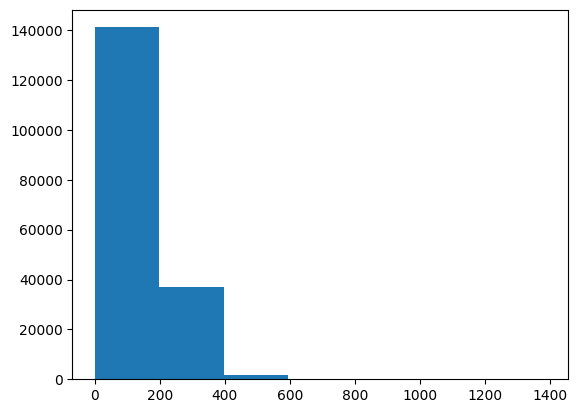

In [73]:
# The avg character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
print(mean_char_len)
# Check the distribution of sequence
plt.hist(char_lens, bins=7)

In [74]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [75]:
#! Get all keyboard character
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [77]:
# Create char_level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [80]:
# Adapt
char_vectorizer.adapt(train_chars)
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters:{char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters:['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [83]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e r e   w e r e   n o   c o m p l i c a t i o n s   d u r i n g   a l l   e x a m s   .

Length of chars: 39

Vectorized chars:
[[ 3 13  2  8  2 20  2  8  2  6  7 11  7 15 14 12  4 11  5  3  4  7  6  9
  10 16  8  4  6 18  5 12 12  2 24  5 15  9  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0 

You'll notice sequences with a length shorter than 290 (output_seq_char_length) get padded with zeros on the end, this ensures all sequences passed to our model are the same length.

Also, due to the standardize parameter of TextVectorization being "lower_and_strip_punctuation" and the split parameter being "whitespace" by default, symbols (such as @) and spaces are removed.



### Create a character-level embedding layer

In [84]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h e r e   w e r e   n o   c o m p l i c a t i o n s   d u r i n g   a l l   e x a m s   .

Embedded chars (after vectorization and embedding):
[[[-0.00816376 -0.00992208  0.0140461  ...  0.0377924  -0.04785042
    0.03958846]
  [ 0.03533461  0.00759042 -0.03479784 ...  0.03956758 -0.00561676
    0.01952294]
  [-0.01563631 -0.03483163  0.01282981 ...  0.03083361  0.02515569
    0.01869691]
  ...
  [ 0.04328291  0.03092641  0.0457021  ...  0.01056044  0.00776689
    0.0261101 ]
  [ 0.04328291  0.03092641  0.0457021  ...  0.01056044  0.00776689
    0.0261101 ]
  [ 0.04328291  0.03092641  0.0457021  ...  0.01056044  0.00776689
    0.0261101 ]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [85]:
def build_model(char_vectorizer, char_embed, num_classes: int):
    """
    Build a Conv1D text classification model on character embeddings.
    
    Args:
        char_vectorizer: TextVectorization layer (char-level).
        char_embed: Embedding layer for characters.
        num_classes: số lớp output (phân loại).
    
    Returns:
        tf.keras.Model
    """
    # Input:
    inputs = tf.keras.layers.Input(shape=(1,), dtype = tf.string)
    
    # Vectorize -> Embedding
    char_vectors = char_vectorizer(inputs)
    char_embeddings = char_embed(char_vectors)
    
    # Conv1D + GlobalMaxPool
    x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
    x = tf.keras.layers.GlobalMaxPool1D()(x)
    
    # Dense output
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs,
                            outputs=outputs,
                            name="model_3_conv1D_char_embedding")
    
    return model

In [87]:
model_3 = build_model(char_vectorizer, char_embed, num_classes=5)
model_3.summary()

Model: "model_3_conv1D_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embed (Embedding)          │ (None, 290, 25)        │         1,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 290, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,139 (39.61 KB)

 Trainable params: 10,139 (39.61 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [89]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [90]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.4120 - loss: 1.4012 - val_accuracy: 0.5715 - val_loss: 1.0733
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5771 - loss: 1.0562 - val_accuracy: 0.6260 - val_loss: 0.9709
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6250 - loss: 0.9554 - val_accuracy: 0.6662 - val_loss: 0.8868


### Evaluate model 3

In [91]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6568 - loss: 0.8980


[0.8999190330505371, 0.6540778279304504]

In [92]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


{'accuracy': 65.40778498609824,
 'precision': 0.6478562482157013,
 'recall': 0.6540778498609824,
 'f1': 0.6425626727792875}

In [93]:
compare_results(model_1_results, model_3_results)

+-----------+----------+---------+----------+--------+
|  Metric   | Baseline |   New   |   Diff   | Status |
+-----------+----------+---------+----------+--------+
|    f1     |  0.7821  | 0.6426  | -0.1396  | Lower  |
| precision |  0.7813  | 0.6479  | -0.1334  | Lower  |
| accuracy  | 78.4457  | 65.4078 | -13.0379 | Lower  |
|  recall   |  0.7845  | 0.6541  | -0.1304  | Lower  |
+-----------+----------+---------+----------+--------+


[['f1', 0.7821, 0.6426, -0.1396, 'Lower'],
 ['precision', 0.7813, 0.6479, -0.1334, 'Lower'],
 ['accuracy', 78.4457, 65.4078, -13.0379, 'Lower'],
 ['recall', 0.7845, 0.6541, -0.1304, 'Lower']]

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)
